In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Stock prediction using tensorflow and LSTM

steps 
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# requirement
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 4.3 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=1cb5b12b6bf22148bc020027fc975332bb21ae76da10eb472493327712dd326d
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=8ab8e79c065d1180cd1412d88bd7d46519774af690828f519ccf05a724ec9680
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=9c7afcb02e169ec5a7f0ddc7856e63688cd5549cc950d716168e13571443d61f
  Stored in directory: /root/.cache/pip/wheels/

In [2]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as tm
import datetime as dt
import tensorflow as tf

# data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout



setting for neural network

In [44]:
# setting 

# window size or the sequence length 7(1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tommorrow
LOOKUP_STEPS = [1,2,3]

# stock ticker, GOOGL
STOCK = "GOOGL"

# current data
date_now = tm.strftime("%Y-%m-%d")
date_3_years_back = (dt.date.today() - dt.timedelta(days = 1184)).strftime("%Y-%m-%d")

Load data

In order to work with data we need to load it from Yahoo Finance. In our example we load 1104 bars with interval 1d (one day).

In [28]:
# load data
# from yahoo_fin from 1104 bars with interval = 1d

init_df = yf.get_data(STOCK,
                     start_date = date_3_years_back,
                     end_date = date_now,
                     interval = "1d")

In [29]:
init_df

,open,high,low,close,adjclose,volume,ticker
2019-08-12,59.000000,59.280499,58.436001,58.724998,58.724998,22064000,GOOGL
2019-08-13,58.717499,60.271500,58.649502,59.836498,59.836498,28434000,GOOGL
2019-08-14,58.803501,59.139500,58.053501,58.212502,58.212502,35430000,GOOGL
2019-08-15,58.421501,58.820999,58.150002,58.466000,58.466000,28506000,GOOGL
2019-08-16,59.039501,59.192001,58.650002,58.960499,58.960499,24916000,GOOGL
...,...,...,...,...,...,...,...
2022-10-31,95.419998,96.029999,93.980003,94.510002,94.510002,31675000,GOOGL
2022-11-01,95.449997,96.029999,90.370003,90.470001,90.470001,47161400,GOOGL
2022-11-02,90.940002,91.180000,86.879997,86.970001,86.970001,57038300,GOOGL
2022-11-03,86.320000,86.519997,83.339996,83.430000,83.430000,61288000,GOOGL


In [30]:
init_df.isna().sum()

open        0
high        0
low         0
close       0
adjclose    0
volume      0
ticker      0
dtype: int64

In [31]:
init_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 817 entries, 2019-08-12 to 2022-11-04
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      817 non-null    float64
 1   high      817 non-null    float64
 2   low       817 non-null    float64
 3   close     817 non-null    float64
 4   adjclose  817 non-null    float64
 5   volume    817 non-null    int64  
 6   ticker    817 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 51.1+ KB


In [32]:
# remove columns which our neural network will not use
init_df = init_df.drop(["open","high","low","adjclose","ticker","volume"],axis = 1)

# create the columns "date" based on the index columns

init_df["date"] = init_df.index

In [33]:
init_df

,close,date
2019-08-12,58.724998,2019-08-12
2019-08-13,59.836498,2019-08-13
2019-08-14,58.212502,2019-08-14
2019-08-15,58.466000,2019-08-15
2019-08-16,58.960499,2019-08-16
...,...,...
2022-10-31,94.510002,2022-10-31
2022-11-01,90.470001,2022-11-01
2022-11-02,86.970001,2022-11-02
2022-11-03,83.430000,2022-11-03


It is just only 2 columns: 'close' and 'date'. we will use them further on.

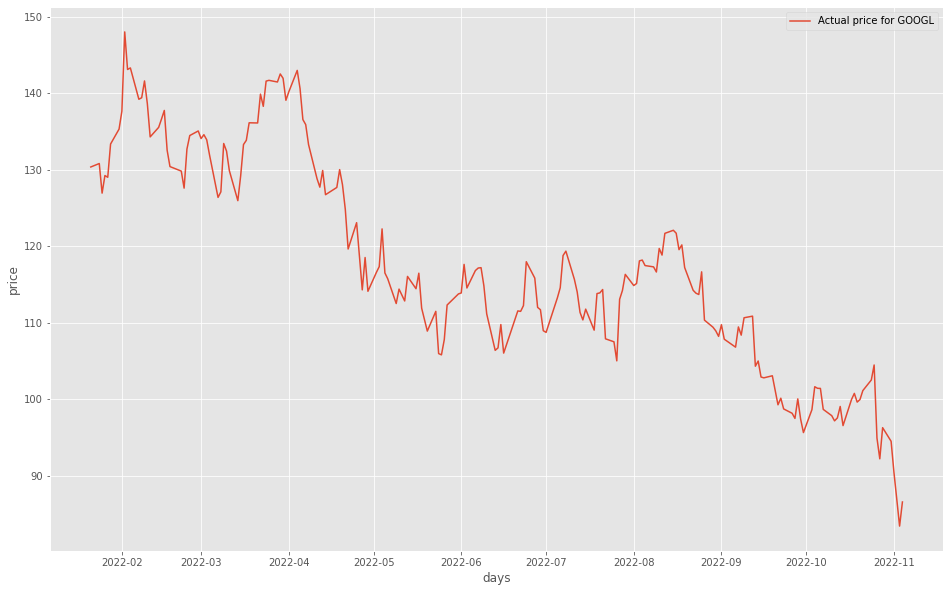

In [34]:
# visualize the data

plt.style.use("ggplot")
plt.figure(figsize = (16,10))
plt.plot(init_df["close"][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f"Actual price for {STOCK}"])
plt.show()

Scale data

As we use LSTM neural network we need to scale the data in the column ‘Close’ because the machine learning algorithm works much better with scaled than with regular data. 

In [35]:
# scale data with ML engine
scaler = MinMaxScaler()
init_df["scaled_close"] = scaler.fit_transform(np.expand_dims(init_df["close"].values, axis = 1))

In [36]:
init_df

,close,date,scaled_close
2019-08-12,58.724998,2019-08-12,0.061962
2019-08-13,59.836498,2019-08-13,0.073405
2019-08-14,58.212502,2019-08-14,0.056686
2019-08-15,58.466000,2019-08-15,0.059296
2019-08-16,58.960499,2019-08-16,0.064387
...,...,...,...
2022-10-31,94.510002,2022-10-31,0.430378
2022-11-01,90.470001,2022-11-01,0.388785
2022-11-02,86.970001,2022-11-02,0.352752
2022-11-03,83.430000,2022-11-03,0.316307


scaled_close price is scaled between 0 to 1.

Prepare data for the engine

So, we have data, preliminary loaded and scaled for the machine learning model. However, we need to prepare it for the next procedure. And here’s why.

Our initial goal is to predict the stock price for the upcoming three days. It means that we have to shift bars on number of days we want to predict it for and prepare the data for the model accordingly.

In our case, the column ‘close’ is the target column and we will shift it and save the results in the column ‘future’. This is our shift itself.

In [37]:
def PrepareData(days):
    df = init_df.copy()
    df["future"] = df["scaled_close"].shift(-days)
    last_sequence = np.array(df[["scaled_close"]].tail(days))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)
    
    for entry, target in zip(df[["scaled_close"] + ['date']].values, df["future"].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences),target])
            
    last_sequence = list([s[:len(["scaled_close"])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype('float')
    
    # construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)
        
    # convert to numpy array
    X = np.array(X)
    Y = np.array(Y)
    
    return df, last_sequence, X, Y

In [38]:
PrepareData(3) # 3 days

(                close       date  scaled_close    future
 2019-08-12  58.724998 2019-08-12      0.061962  0.059296
 2019-08-13  59.836498 2019-08-13      0.073405  0.064387
 2019-08-14  58.212502 2019-08-14      0.056686  0.075315
 2019-08-15  58.466000 2019-08-15      0.059296  0.066610
 2019-08-16  58.960499 2019-08-16      0.064387  0.070754
 ...               ...        ...           ...       ...
 2022-10-26  94.930000 2022-10-26      0.434702  0.430378
 2022-10-27  92.220001 2022-10-27      0.406802  0.388785
 2022-10-28  96.290001 2022-10-28      0.448704  0.352752
 2022-10-31  94.510002 2022-10-31      0.430378  0.316307
 2022-11-01  90.470001 2022-11-01      0.388785  0.348737
 
 [814 rows x 4 columns],
 array([[0.5128433 ],
        [0.5330221 ],
        [0.43470225],
        [0.40680209],
        [0.44870382],
        [0.43037826],
        [0.38878537],
        [0.35275193],
        [0.31630667],
        [0.34873678]]),
 array([[[0.0619620461735777, Timestamp('2019-08-12 00:

Also, in this script we need to calculate the last sequence which has the last window for the engine. We will predict prices for future days using that sequence.

Final things are the arrays of X’s and Y’s for the LSTM. X’s is the array of sequence on the particular step. The Y’s is array of target price on the particular step.

# Machine Learning Model

In [50]:
def GetTrainedModel(x_train, y_train):
    model = Sequential()
    model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
    model.add(Dropout(0.3))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

    BATCH_SIZE = 8
    EPOCHS = 80

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

    model.summary()

    return model

    

Predict stock prices

Now we have everything we need to start predicting the GOOGL prices for the upcoming 3 days.

In the following script we initialize the array of predicted prices. Then, in the loop we prepare the data and train the model on each step (for each day from our array of days [1, 2, 3])

In [51]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
    df, last_sequence, x_train, y_train = PrepareData(step)
    x_train = x_train[:, :, :len(['scaled_close'])].astype('float')

    model = GetTrainedModel(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))

Epoch 1/80
102/102 [==============================] - 4s 5ms/step - loss: 0.0237
Epoch 2/80
102/102 [==============================] - 1s 5ms/step - loss: 0.0039
Epoch 3/80
102/102 [==============================] - 1s 5ms/step - loss: 0.0037
Epoch 4/80
102/102 [==============================] - 1s 5ms/step - loss: 0.0034
Epoch 5/80
102/102 [==============================] - 1s 5ms/step - loss: 0.0036
Epoch 6/80
102/102 [==============================] - 1s 5ms/step - loss: 0.0027
Epoch 7/80
102/102 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 8/80
102/102 [==============================] - 1s 5ms/step - loss: 0.0024
Epoch 9/80
102/102 [==============================] - 1s 5ms/step - loss: 0.0026
Epoch 10/80
102/102 [==============================] - 1s 5ms/step - loss: 0.0024
Epoch 11/80
102/102 [==============================] - 1s 5ms/step - loss: 0.0025
Epoch 12/80
102/102 [==============================] - 1s 5ms/step - loss: 0.0022
Epoch 13/80
102/102 [====

In [59]:
if bool(predictions) == True and len(prediction)> 0:
    prediction_list = [str(d) + '$' for d in predictions]
    predictions_str = ','.join(predictions_list)
    massage = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
    
print(massage)

GOOGL prediction for upcoming 3 days (85.75$,84.3$,86.3$)


Accuracy is 98%.

 there is the “loss” which is equal to 0,0023 what is approximately 2% from our scaled values.

# Result Chart

In [62]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6],axis = 1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis = 1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f"predicted_close"] = y_predicted_transformed

In [63]:
copy_df

,close,date,scaled_close,predicted_close
2019-08-12,58.724998,2019-08-12,0.061962,57.679001
2019-08-13,59.836498,2019-08-13,0.073405,58.558998
2019-08-14,58.212502,2019-08-14,0.056686,58.541000
2019-08-15,58.466000,2019-08-15,0.059296,58.687500
2019-08-16,58.960499,2019-08-16,0.064387,59.712002
...,...,...,...,...
2022-10-31,94.510002,2022-10-31,0.430378,95.120491
2022-11-01,90.470001,2022-11-01,0.388785,92.962708
2022-11-02,86.970001,2022-11-02,0.352752,86.970001
2022-11-03,83.430000,2022-11-03,0.316307,83.430000


In [64]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

In [65]:
copy_df.head()

,close,date,scaled_close,predicted_close
2019-08-12 00:00:00,58.724998,2019-08-12 00:00:00,0.061962,57.679001
2019-08-13 00:00:00,59.836498,2019-08-13 00:00:00,0.073405,58.558998
2019-08-14 00:00:00,58.212502,2019-08-14 00:00:00,0.056686,58.541000
2019-08-15 00:00:00,58.466000,2019-08-15 00:00:00,0.059296,58.687500
2019-08-16 00:00:00,58.960499,2019-08-16 00:00:00,0.064387,59.712002


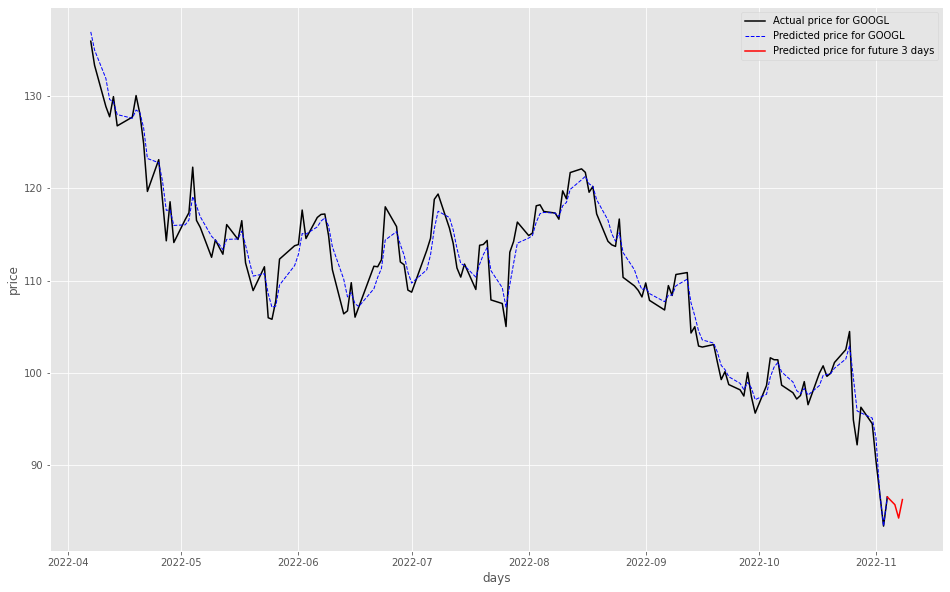

In [71]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147),color = "black")
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed', color = "blue")
plt.plot(copy_df['close'][-150:].tail(4),color = 'red')
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])